In [ ]:
# Dowlnoad dataset from Roboflow all 4 versions

from roboflow import Roboflow
rf = Roboflow(api_key="jTrkQDoEM9XSpBu2Dm3G")
project = rf.workspace("personal-protective-equipment").project("ppes-kaxsi")
dataset_v_1 = project.version(1).download("yolov8")
dataset_v_2 = project.version(2).download("yolov8")
dataset_v_3 = project.version(3).download("yolov8")
dataset_v_4 = project.version(4).download("yolov8")


In [10]:
# Setup paths to labels and images

all_labels_paths = ["PPEs-1/train/labels", "PPEs-1/valid/labels", "PPEs-2/train/labels", "PPEs-2/valid/labels", "PPEs-3/train/labels", "PPEs-3/valid/labels", "PPEs-4/train/labels", "PPEs-4/valid/labels"]
all_images_paths = ["PPEs-1/train/images", "PPEs-1/valid/images", "PPEs-2/train/images", "PPEs-2/valid/images", "PPEs-3/train/images", "PPEs-3/valid/images", "PPEs-4/train/images", "PPEs-4/valid/images"]

<function stdev_size at 0x0000025791476700>


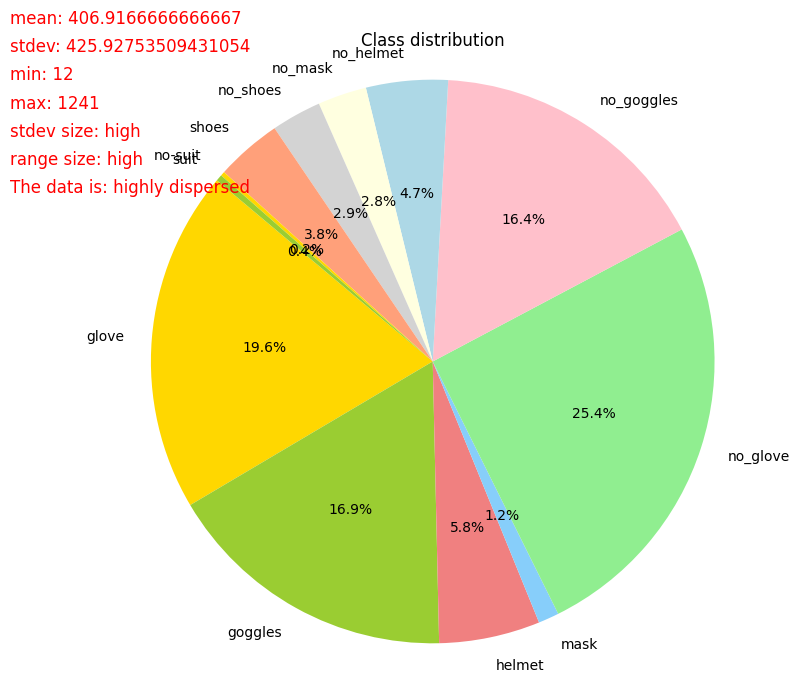

In [3]:
# Analize balance of classes in dataset

import os
import yaml
import matplotlib.pyplot as plt
import statistics
from collections import Counter
from concurrent.futures import ThreadPoolExecutor

def stdev_size(data: dict) -> str:
    stdev = statistics.stdev(data)
    mean = statistics.mean(data)
    cv = stdev / mean
    if cv <= 0.33:
        return "low", 0
    elif cv <= 0.66:
        return "medium", 1
    else:
        return "high", 2

def range_size(data: dict) -> str:
    range_value = max(data) - min(data)
    percentage_difference = (range_value / max(data)) * 100
    if percentage_difference <= 33:
        return "low", 0
    elif percentage_difference <= 66:
        return "medium", 1
    else:
        return "high", 2

def overall_size(data: [int]) -> str:
    #sum the data
    sum = 0
    for i in data:
        sum += i
    if sum <= 0:
        return "no dispersion", 0
    elif sum <= 1:
        return "slightly dispersed", 1
    elif sum <= 2:
        return "moderately dispersed", 2
    else:
        return "highly dispersed", 3
        

def get_classes_names_count(yaml_file_path: str, folder_path: str) -> dict:
    with open(yaml_file_path, 'r') as stream:
        classes_names = yaml.safe_load(stream)['names']
    classes_names_count = {item: 0 for item in classes_names}

    # Use multi-threading to read the label file in parallel
    with ThreadPoolExecutor() as executor:
        # Iterate over the files in the folder
        for filename in os.listdir(folder_path):
            file_path = os.path.join(folder_path, filename)
            # Submit the read_label_file function to the executor
            future = executor.submit(read_label_file, file_path, classes_names, classes_names_count)
    
    return classes_names_count

def read_label_file(file_path: str, classes_names: list, classes_names_count: dict):
    # Security check if file is a file
    if os.path.isfile(file_path):
        with open(file_path, 'r') as f:
            for line in f:
                # Get the class name and increment the corresponding value
                class_name = classes_names[int(line.split()[0])]
                classes_names_count[class_name] += 1

def generate_pie_chart(classes_names_count: dict):
    plt.figure(figsize=(8, 8))

    # Nazwy kategorii (klas)
    labels = classes_names_count.keys()
    sizes = classes_names_count.values()


    mean = statistics.mean(sizes)
    stdev = statistics.stdev(sizes)
    min_value = min(sizes)
    max_value = max(sizes)
    
    stdev_size_str, stdev_size_value = stdev_size(sizes)
    range_size_str, range_size_value = range_size(sizes)
    overall_size_str, overall_size_value = overall_size([stdev_size_value, range_size_value])
    
    print(stdev_size)

    stats = {
        "mean": mean,
        "stdev": stdev,
        "min": min_value,
        "max": max_value,
        "stdev size": stdev_size_str,
        "range size": range_size_str,
        "The data is": overall_size_str
    }

    colors = ['gold', 'yellowgreen', 'lightcoral', 'lightskyblue', 'lightgreen', 'pink', 'lightblue', 'lightyellow', 'lightgray', 'lightsalmon']

    plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
    plt.axis('equal')
    plt.title("Class distribution")

    for i, (key, value) in enumerate(stats.items()):
        color = 'green' if overall_size_value == '0' else 'yellow' if overall_size_value == '1' else 'orange' if overall_size_value == '2' else 'red'
        plt.text(-1.5, 1.2 - i * 0.1, f"{key}: {value}", fontsize=12, color=color)


    plt.show()

def merge_dicts(*dict_args):
    result = {}
    for dictionary in dict_args:
        result.update(dictionary)
    return result

# Define the paths to the YAML files and label folders
yaml_file_paths = ["PPEs-1/data.yaml", "PPEs-2/data.yaml", "PPEs-3/data.yaml", "PPEs-4/data.yaml"]

# Get the classes names count for each dataset
classes_names_counts = [get_classes_names_count(yaml_file_path, folder_path) for yaml_file_path, folder_path in zip(yaml_file_paths, all_labels_paths)]

# Merge the dictionaries
classes_names_count_all = merge_dicts(*classes_names_counts)

# Generate the pie chart
generate_pie_chart(classes_names_count_all)

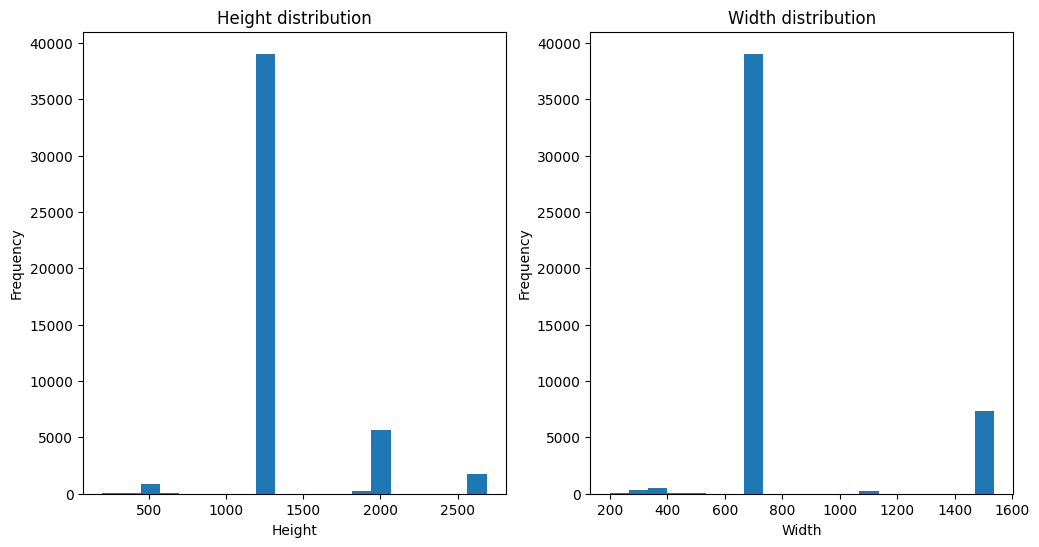

In [5]:
# Analize the size of images
import os
from PIL import Image
from concurrent.futures import ThreadPoolExecutor
import matplotlib.pyplot as plt

def get_image_size(folder_path: str) -> list:
    all_heights_widths = []
    
    # Define a function to get the size of the image
    def get_image_size(file_path):
        with Image.open(file_path) as img:
            return img.size
    
    # Use multi-threading to get the sizes in parallel
    with ThreadPoolExecutor() as executor:
        # Iterate over the files in the folder
        for entry in os.scandir(folder_path):
            if entry.is_file():
                file_path = entry.path
                # Submit the get_image_size function to the executor
                future = executor.submit(get_image_size, file_path)
                all_heights_widths.append(future.result())
    
    return all_heights_widths

def generate_histogram(all_heights_widths: list):
    # Get the heights and widths
    heights = [height for height, width in all_heights_widths]
    widths = [width for height, width in all_heights_widths]

    # Plot the histograms
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.hist(heights, bins=20)
    plt.title("Height distribution")
    plt.xlabel("Height")
    plt.ylabel("Frequency")
    plt.subplot(1, 2, 2)
    plt.hist(widths, bins=20)
    plt.title("Width distribution")
    plt.xlabel("Width")
    plt.ylabel("Frequency")
    plt.show()

all_heights_widths_all = [size for path in all_images_paths for size in get_image_size(path)]

generate_histogram(all_heights_widths_all)

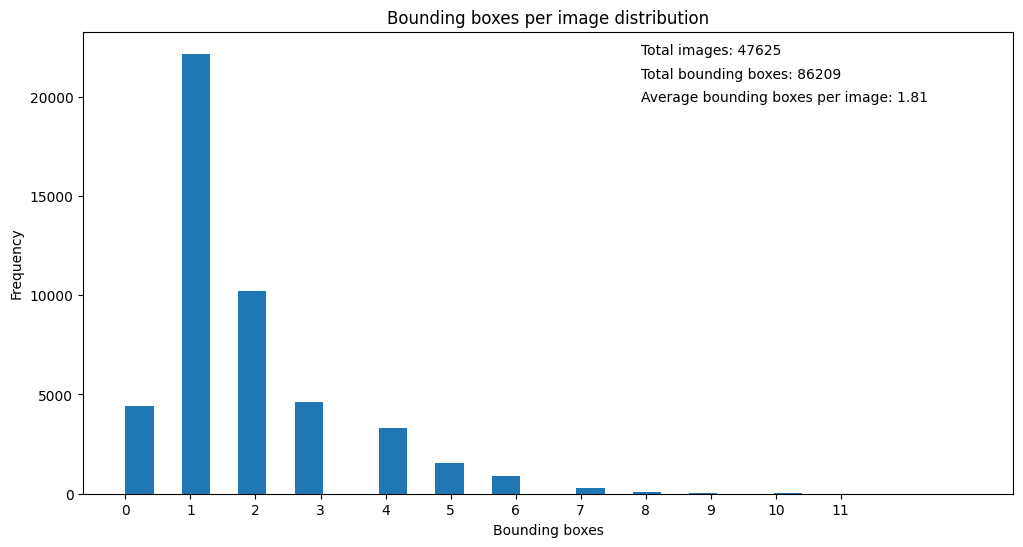

In [16]:
# Analize count of bounding boxes per image
import os
import matplotlib.pyplot as plt
from concurrent.futures import ThreadPoolExecutor

def get_bounding_boxes_count(folder_path: str) -> list:
    all_bounding_boxes_count = []
    
    # Define a function to get the count of bounding boxes
    def get_bounding_boxes_count(file_path):
        with open(file_path, 'r') as f:
            return len(f.readlines())
    
    # Use multi-threading to get the counts in parallel
    with ThreadPoolExecutor() as executor:
        # Iterate over the files in the folder
        for filename in os.listdir(folder_path):
            file_path = os.path.join(folder_path, filename)
            # Submit the get_bounding_boxes_count function to the executor
            future = executor.submit(get_bounding_boxes_count, file_path)
            all_bounding_boxes_count.append(future.result())
    
    return all_bounding_boxes_count

def get_image_count(folder_path: str) -> int:
    return len(os.listdir(folder_path))

def generate_histogram(all_bounding_boxes_count: list, all_images_count: int, average_bounding_boxes_per_image: float, total_bounding_boxes: int):
    total_bounding_boxes = sum(all_bounding_boxes_count)
    average_bounding_boxes_per_image = total_bounding_boxes / all_images_count
    
    plt.figure(figsize=(12, 6))
    n, bins, patches = plt.hist(all_bounding_boxes_count, bins=30)
    plt.title("Bounding boxes per image distribution")
    plt.xlabel("Bounding boxes")
    plt.ylabel("Frequency")
    plt.xticks(range(0, 12, 1))
    plt.text(0.6, 0.95, f"Total images: {all_images_count}", transform=plt.gca().transAxes)
    plt.text(0.6, 0.9, f"Total bounding boxes: {total_bounding_boxes}", transform=plt.gca().transAxes)
    plt.text(0.6, 0.85, f"Average bounding boxes per image: {average_bounding_boxes_per_image:.2f}", transform=plt.gca().transAxes)
    plt.show()


all_bounding_boxes_count_all = [size for path in all_labels_paths for size in get_bounding_boxes_count(path)]
all_images_count = sum([get_image_count(path) for path in all_images_paths])

generate_histogram(all_bounding_boxes_count_all, all_images_count, sum(all_bounding_boxes_count_all) / all_images_count, sum(all_bounding_boxes_count_all))

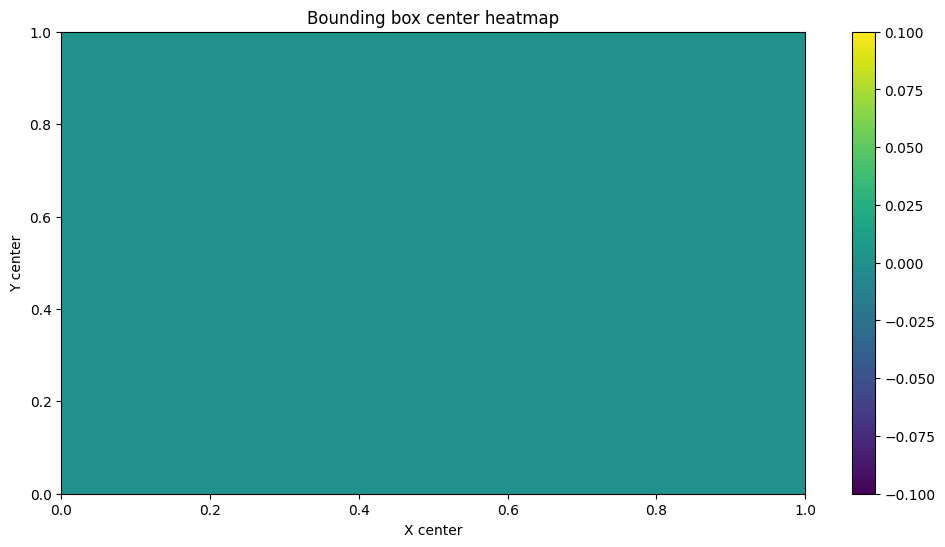

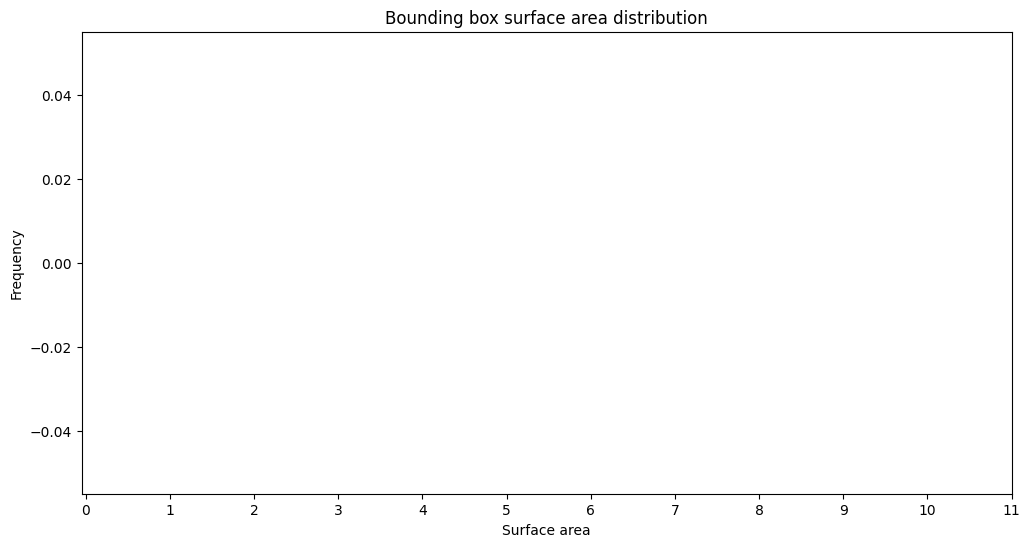

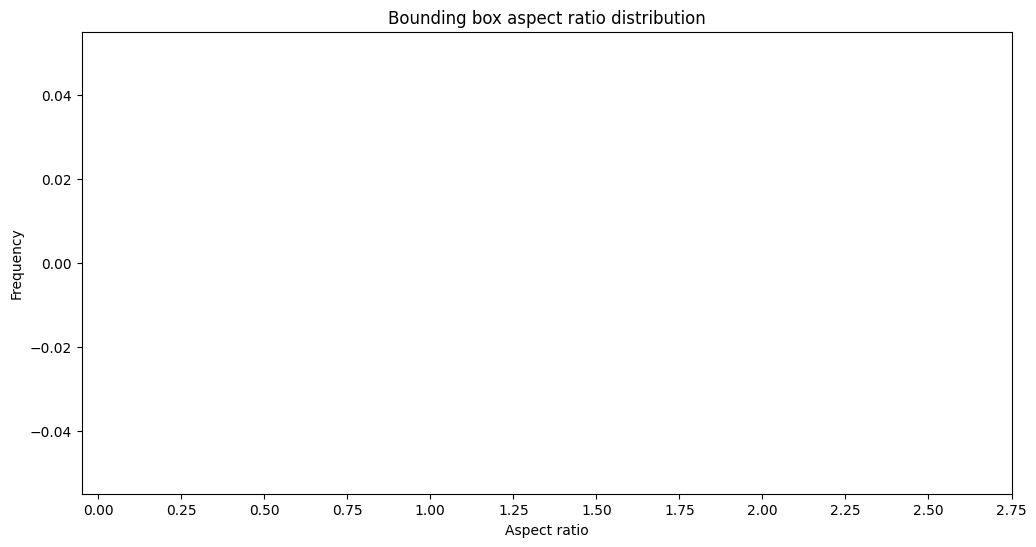

In [11]:
# Analize the properties of bounding boxes
import os
import matplotlib.pyplot as plt
from concurrent.futures import ThreadPoolExecutor
import numpy as np

def get_bounding_boxes_properties(folder_path: str) -> list:
    all_bounding_boxes_properties = []
    
    # Define a function to get the properties of the bounding boxes
    def get_bounding_boxes_properties(file_path):
        with open(file_path, 'r') as f:
            for line in f:
                # Get the properties of the bounding box
                class_index, x_center, y_center, width, height = line.split()
                all_bounding_boxes_properties.append([float(x_center), float(y_center), float(width), float(height)])
    
    # Use multi-threading to get the properties in parallel
    with ThreadPoolExecutor() as executor:
        # Iterate over the files in the folder
        for filename in os.listdir(folder_path):
            file_path = os.path.join(folder_path, filename)
            # Submit the get_bounding_boxes_properties function to the executor
            future = executor.submit(get_bounding_boxes_properties, file_path)
    
    return all_bounding_boxes_properties

def generate_heatmap(all_bounding_boxes_properties: list):
    # Get the properties of the bounding boxes
    x_centers = [x_center for x_center, y_center, width, height in all_bounding_boxes_properties]
    y_centers = [y_center for x_center, y_center, width, height in all_bounding_boxes_properties]

    # Plot the heatmaps
    plt.figure(figsize=(12, 6))
    plt.hist2d(x_centers, y_centers, bins=20)
    plt.title("Bounding box center heatmap")
    plt.xlabel("X center")
    plt.ylabel("Y center")
    plt.colorbar()
    plt.show()

def get_surface_area(data: list) -> list:
    surface_areas = []
    for x_center, y_center, width, height in data:
        surface_areas.append(width * height * 100)
    return surface_areas

def get_aspect_ratio(data: list) -> list:
    aspect_ratios = []
    for x_center, y_center, width, height in data:
        aspect_ratios.append(width / height)
    return aspect_ratios


def generate_histogram(data: list, title: str, x_label: str, y_label: str, min : float = 0, max : float = 12, step : float = 1):
    plt.figure(figsize=(12, 6))
    plt.hist(data, bins=80)
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.xticks(np.arange(min, max, step))
    plt.show()

all_bounding_boxes_count_all = [size for path in all_images_paths for size in  get_bounding_boxes_properties(path)]


generate_heatmap(all_bounding_boxes_count_all)
generate_histogram(get_surface_area(all_bounding_boxes_count_all), "Bounding box surface area distribution", "Surface area", "Frequency")
generate_histogram(get_aspect_ratio(all_bounding_boxes_count_all), "Bounding box aspect ratio distribution", "Aspect ratio", "Frequency", 0, 3, 0.25)

In [ ]:
#TODO - format code
#TODO - add comments
#TODO - how many photos per class
#TODO - how many bounding boxes per class
#TODO - how many bounding boxes per class per photo
#TODO - how many bounding boxes per photo
#TODO - how many of each class per photo
#TODO - how many various class per photo
#TODO - how many photos are made by CCTV
#TODO - how many photos are similar to other photos
#TODO - how many photos are similar to other photos in other datasets 